In [1]:
import torch

from math import ceil

from botorch.models.transforms.input import AppendFeatures
from botorch.utils.transforms import normalize, unnormalize

from scalarize.test_functions.multi_objective import RocketInjector
from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
def get_cvar_pareto_surface(
    ys, n_w, nadir, grid_length, alpha, output_bounds, dtype, device
):

    cvar_num = n_w - ceil(n_w * alpha) + 1
    num_objectives = output_bounds.shape[-1]

    normalized_ys = [normalize(y, output_bounds) for y in ys]
    unit_vector = UnitVector(num_objectives=num_objectives, transform_label="polar")

    u = torch.linspace(0, 1, grid_length, **tkwargs)
    WX, WY = torch.meshgrid(u, u, indexing="xy")
    Z = torch.zeros(grid_length * grid_length, num_objectives, **tkwargs)

    normalized_nadir = normalize(nadir, output_bounds)

    for i in range(grid_length):
        for j in range(grid_length):
            index = i * grid_length + j
            Wij = torch.column_stack([WX[i, j], WY[i, j]])
            weights = unit_vector(Wij)

            s_fn = LengthScalarization(weights=weights, ref_points=normalized_nadir)

            cvar_length = None
            for y in normalized_ys:
                cvar_length_x = (
                    s_fn(y)
                    .topk(cvar_num, dim=0, largest=False)
                    .values.mean(dim=0)
                    .unsqueeze(-1)
                )
                if cvar_length is None:
                    cvar_length = cvar_length_x
                else:
                    cvar_length = torch.maximum(cvar_length, cvar_length_x)

            pareto_point = normalized_nadir + cvar_length * weights
            Z[index, ...] = unnormalize(pareto_point, output_bounds)

    return Z.reshape(grid_length, grid_length, num_objectives)

In [3]:
problem = RocketInjector(negate=True)
initial_data = torch.load("data/initial_rocket_data.pt")

noise_grid = initial_data["noise_grid"]
nadir = initial_data["ref_point"]
weights = initial_data["weights"]
alpha = initial_data["alpha"]
output_bounds = initial_data["output_bounds"]
num_initial_points = initial_data["num_initial_points"]
tkwargs = initial_data["tkwargs"]

input_transform = AppendFeatures(feature_set=noise_grid).eval()

In [4]:
algo = "sobol"
grid_length = 100
seed = 77
data = torch.load(f"data/rocket_feature/{str(seed).zfill(4)}_{algo}.pt")

X = data["X"][:num_initial_points]
Y = data["Y"][:num_initial_points]
utility = data["utilities"][0]

X_set = [input_transform(x.unsqueeze(0)) for x in X]
Y_set = [problem(x) for x in X_set]

pareto_surface = get_cvar_pareto_surface(
    ys=Y_set,
    n_w=len(noise_grid),
    nadir=nadir,
    grid_length=grid_length,
    alpha=alpha,
    output_bounds=output_bounds,
    **tkwargs,
)

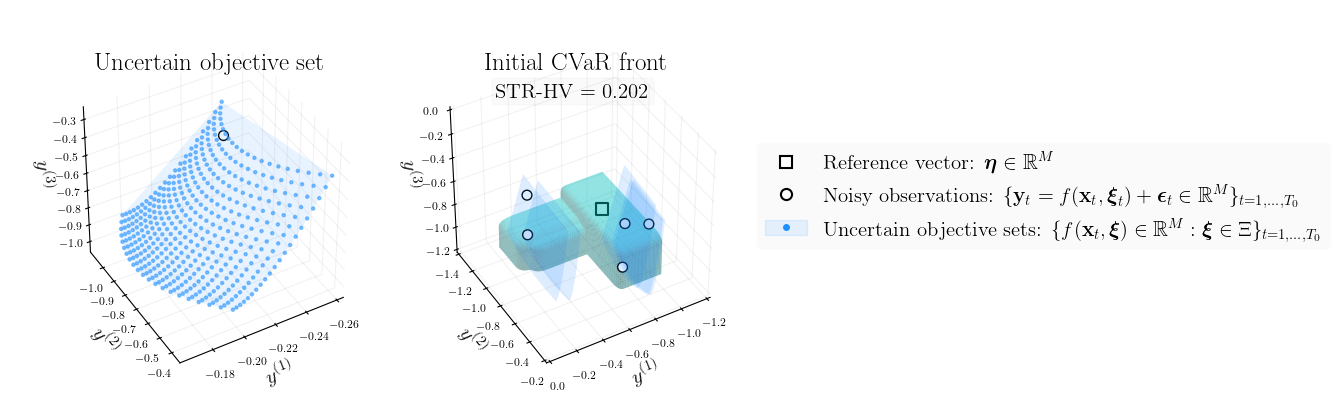

In [5]:
fig, axes = plt.subplots(figsize=(11, 4))
axes.remove()
plt.rcParams["grid.color"] = (0.5, 0.5, 0.5, 0.1)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

gs = fig.add_gridspec(4, 6)
####################################################################################################
ax = fig.add_subplot(gs[0:4, 0:4], projection="3d")

n = 0
ax.scatter(
    xs=Y[n, 0],
    ys=Y[n, 1],
    zs=Y[n, 2],
    alpha=1.0,
    marker="o",
    edgecolor="k",
    color="w",
    s=50,
)
z = Y_set[n]
ax.scatter(
    xs=z[:, 0],
    ys=z[:, 1],
    zs=z[:, 2],
    alpha=0.5,
    s=5,
    color="dodgerblue",
)

ax.plot_trisurf(
    z[:, 0], z[:, 1], z[:, 2], color="dodgerblue", alpha=0.1, linewidth=0, shade=False
)
ax.set_xlabel(r"$y^{(1)}$", fontsize=15)
ax.set_ylabel(r"$y^{(2)}$", fontsize=15)
ax.set_zlabel(r"$y^{(3)}$", fontsize=15)
ax.view_init(40, 60)

ax.set_box_aspect(aspect=(1, 1, 1), zoom=0.8)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor("w")
ax.yaxis.pane.set_edgecolor("w")
ax.zaxis.pane.set_edgecolor("w")

ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.tick_params(axis="z", labelsize=8)

ax.set_title("Uncertain objective set", fontsize=18, y=0.9)
####################################################################################################
ax = fig.add_subplot(gs[0:4, 2:6], projection="3d")

ax.scatter(
    xs=Y[:, 0],
    ys=Y[:, 1],
    zs=Y[:, 2],
    alpha=1,
    marker="o",
    edgecolor="k",
    color="w",
    s=50,
)

for z in Y_set:
    ax.plot_trisurf(
        z[:, 0],
        z[:, 1],
        z[:, 2],
        color="dodgerblue",
        alpha=0.15,
        linewidth=0,
        shade=False,
    )

surf = ax.plot_surface(
    pareto_surface[..., 0],
    pareto_surface[..., 1],
    pareto_surface[..., 2],
    alpha=0.5,
    rstride=1,
    cstride=1,
    color="cyan",
    shade=True,
)

ax.scatter(
    xs=nadir[0],
    ys=nadir[1],
    zs=nadir[2],
    color="w",
    marker="s",
    linestyle="None",
    s=70,
    edgecolors="k",
    linewidth=1.5,
)

ax.set_xlabel(r"$y^{(1)}$", fontsize=15)
ax.set_ylabel(r"$y^{(2)}$", fontsize=15)
ax.set_zlabel(r"$y^{(3)}$", fontsize=15)
ax.view_init(40, 60)

ax.set_box_aspect(aspect=(1, 1, 1), zoom=0.8)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor("w")
ax.yaxis.pane.set_edgecolor("w")
ax.zaxis.pane.set_edgecolor("w")

ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.tick_params(axis="z", labelsize=8)

ax.set_xlim(-1.2, -0.0)
ax.set_ylim(-1.4, -0.2)
ax.set_zlim(-1.2, -0.0)

ax.text(
    -0.3,
    -1.4,
    0.00,
    f"STR-HV = {utility:.3f}",
    color="black",
    fontsize=15,
    weight="bold",
    bbox=dict(facecolor="k", edgecolor="black", boxstyle="round,pad=0.2", alpha=0.02),
)

ax.set_title("Initial CVaR front", fontsize=18, y=0.9)
####################################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=8,
    markeredgecolor="k",
    markeredgewidth=1.5,
)

white_circle = mlines.Line2D(
    [],
    [],
    color="w",
    marker="o",
    linestyle="None",
    markersize=8,
    markeredgecolor="k",
    markeredgewidth=1.5,
)

blue_patch = mpatches.Patch(
    color="dodgerblue",
    alpha=0.1,
)

blue_circle = mlines.Line2D(
    [],
    [],
    color="dodgerblue",
    marker=".",
    linestyle="None",
    markersize=8,
)

labels = [
    r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
    r"Noisy observations: $\{\mathbf{y}_t = f(\mathbf{x}_t, \boldsymbol{\xi}_t) + \boldsymbol{\epsilon}_t \in \mathbb{R}^M\}_{t=1,\dots,T_0}$",
    r"Uncertain objective sets: $\{f(\mathbf{x}_t, \boldsymbol{\xi}) \in \mathbb{R}^M: \boldsymbol{\xi}\in \Xi\}_{t=1,\dots,T_0}$",
]

ax.legend(
    handles=[
        white_square,
        white_circle,
        (blue_patch, blue_circle),
    ],
    labels=labels,
    loc=(0.95, 0.4),
    ncol=1,
    fontsize=15,
    facecolor="k",
    framealpha=0.02,
)
plt.show()